# Lending Club Loan Default Prediction

Created by Cindy Liu on 10/20/2018

Predict default loan. Binary Classification problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
from sklearn import preprocessing

In [156]:
location='/../Downloads/loan.csv'
df=pd.read_csv(location)
df.shape

(887379, 74)

In [157]:
#make a copy
my_data=df.copy()

# Feature Engineering
## Missing Value Imputation

In [158]:
#sns.heatmap(my_data.isnull(),cbar=False,yticklabels=False)

Impute missing values of annual income

In [159]:
# fill the NA values of annual income with its median, as its dist'n is right skewed
df['annual_inc'] = df['annual_inc'].fillna(value=df['annual_inc'].median())
len(df['annual_inc'])-df['annual_inc'].count()

0

** TO BE IMPROVED ** - KNN?

In [160]:
df['total_acc'] = df['total_acc'].fillna(value=df['total_acc'].median())
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(value=df['tot_cur_bal'].median())
df['open_acc'] = df['open_acc'].fillna(value=df['open_acc'].median())
df['revol_util'] = df['revol_util'].fillna(value=df['revol_util'].median())
df['tot_coll_amt'] = df['tot_coll_amt'].fillna(value=df['tot_coll_amt'].median())
df['total_rev_hi_lim'] = df['total_rev_hi_lim'].fillna(value=df['total_rev_hi_lim'].median())

In [161]:
df['emp_length'].fillna(value='n/a',inplace=True)

## Remove useless features
* Remove most of loan payment related features, since payments were made after interest rates were determined. Hence, they should not be used to predict interest rate.  
* Remove features with unique value per row and with same value across rows (no variance): policy_code, id, member_id, url  
* Remove redundant features: dti_joint, annual_income_joint, and application_type which indicates wheter it's a joint loan, and verification_status_joint
* Drop the features with more than 80% values missing
* Remove emp_title, desc, title, which require text mining
* Remove zip_code, which require external information

In [162]:
payment_related = ['installment','funded_amnt','funded_amnt_inv','last_pymnt_amnt','last_pymnt_d','next_pymnt_d',\
                   'recoveries','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp',\
                   'collection_recovery_fee','out_prncp','out_prncp_inv']
df.drop(payment_related,axis=1,inplace=True)

In [163]:
df['policy_code'].unique() # drop policy code since all loans have policy_code=1
df.drop('policy_code',axis=1,inplace=True)

In [164]:
df.drop(['id','member_id','url'],axis=1,inplace=True)

In [165]:
df['dti_2'] = df['dti_joint'].fillna(df['dti'])
df['annual_inc_2'] = df['annual_inc_joint'].fillna(df['annual_inc'])

In [166]:
df.drop(['dti','dti_joint','annual_inc','annual_inc_joint'],axis=1,inplace=True)

In [167]:
# hence also drop application type and verification_status_joint
df.drop('application_type',axis=1,inplace=True)
df.drop('verification_status_joint',axis=1,inplace=True)

In [168]:
# Drop the features with more than 80% values missing
df = df.dropna(axis=1,thresh=len(df)*0.8)
na_cols = df.shape[0]-df.count()
na_cols[na_cols>0]
df.shape

(887379, 33)

In [169]:
df.drop(['emp_title','title','zip_code'],axis=1,inplace=True)

In [170]:
df.drop(['collections_12_mths_ex_med'],axis=1,inplace=True)

In [171]:
# check number of features left
df.shape

(887379, 29)

## Collapse levels of the categorical features w/ too many levels

 **ADDR_STATE**: 51 levels

In [172]:
state_int_mean=df.groupby('addr_state').mean()['int_rate']
low=[]
medium_low=[]
medium_high=[]
high=[]
for x in df['addr_state'].unique():
    if state_int_mean[x] <= state_int_mean.describe()['25%']:
        low.append(x)
    elif state_int_mean[x]>state_int_mean.describe()['25%'] and state_int_mean[x]<=state_int_mean.mean():
        medium_low.append(x)
    elif state_int_mean[x]>state_int_mean.mean() and state_int_mean[x]<=state_int_mean.describe()['75%']:
        medium_high.append(x)
    else:
        high.append(x)

def collapse(x): 
    if x in low:
        return 'low'
    if x in medium_low:
        return 'medium_low'
    if x in medium_high:
        return 'medium_high'
    else:
        return 'high'

df['addr_state']=df['addr_state'].apply(collapse)

** LOAN PURPOSE **  
From EDA, credit card, car and educational loans have lower interest rate on average. Collapse these three into one level and the rest into one.

In [173]:
# one hot: 0 for credit_card, car, educational, 1 for the others
df['purpose'] = df['purpose'].apply(lambda x: 0 if x in ['credit_card', 'car', 'educational'] else 1)

#### HOME OWNERSHIP

In [174]:
# merge 'ANY','NONE' into 'OTHER'
df['home_ownership'] = df['home_ownership'].apply(lambda x: 'OTHER' if x in ['ANY','NONE'] else x)

## Create new features

** CREDIT HISTORY: ** issue_d - earliest_cr_line

In [175]:
d1=pd.to_datetime(df['earliest_cr_line'],format='%b-%Y')
d2=pd.to_datetime(df['issue_d'],format='%b-%Y')
df['credit_history']=(d2-d1).astype('timedelta64[D]')
df['credit_history'].fillna(value=0,inplace=True)
df.drop(['earliest_cr_line','issue_d'],axis=1,inplace=True)

In [176]:
#df[df['delinq_2yrs'].isnull()].index
#(len(df)-df.count())[(len(df)-df.count())==29]
#df[df['delinq_2yrs'].isnull()].index==my_data[my_data['earliest_cr_line'].isnull()].index

#When the customer doesn't have an earliest credit line, these columns all have NA values
for i in ['delinq_2yrs','inq_last_6mths','pub_rec','acc_now_delinq']:
    df[i].fillna(value=0,inplace=True)

## Define Label: Loan Status

In [177]:
df['loan_status'] = df['loan_status'].str.replace('Does not meet the credit policy. Status.', '')
# drop vague staus
df = df[(df['loan_status']!='Current') & (df['loan_status']!='Issued')]

**0** for bad loan: 'Charged Off', 'Default', 'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)'  
**1** for good loan: 'Fully Paid'

In [178]:
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x=='Fully Paid' else 1)
df['loan_status'].value_counts()

0    209711
1     67429
Name: loan_status, dtype: int64

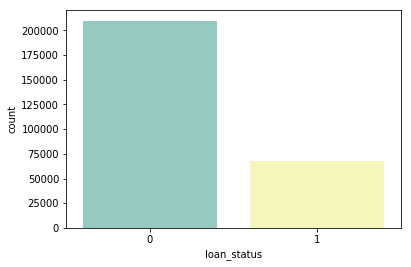

In [179]:
sns.countplot(x='loan_status',data=df,palette='Set3')
plt.show()

In [ ]:
df['loan_status'].unique

## Transform skewed features

In [180]:
#ls=['annual_inc_2', 'dti_2', 'loan_amnt', 'total_acc', 'tot_cur_bal', 'open_acc','credit_history']
numeric_col = [i for i in df if df[i].dtype=='float64']
for i in numeric_col:
    df[i]=stats.boxcox(df[i]+0.01)[0]

## Standardize numeric features

In [181]:
df[numeric_col]=preprocessing.scale(df[numeric_col])

## One hot encoding for categorical variables

In [183]:
df.drop(['last_credit_pull_d','sub_grade'],axis=1,inplace=True)
cate = df.select_dtypes(include=['object']).columns
dummies = pd.get_dummies(df[cate],prefix=cate,drop_first=True)
df.drop(cate,axis=1,inplace=True)
df = pd.concat([df,dummies],axis=1)

#### Save cleaned data to csv file

In [187]:
cleaned_data = '/../Desktop/DS501/LendingClub/lc_cleaned_data.csv'
df.to_csv(cleaned_data,index=False)